In [47]:
# Import the necessary libraries

import warnings

warnings.filterwarnings(action = 'ignore')

import os
import sys
import numpy as np
import cv2
import skvideo.io
import glob
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.applications.vgg16 import VGG16
from tensorflow import keras
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.layers import (Flatten, Dense, Activation, MaxPooling2D, Conv2D, InputLayer)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD

from numba import double, jit, njit, vectorize

import progressbar

import time

import PIL
from PIL import Image, ImageEnhance


from sklearn.metrics import (confusion_matrix, classification_report, ConfusionMatrixDisplay)
from sklearn.utils import shuffle

import pickle

import math   # for mathematical operations

import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images

from moviepy.editor import VideoFileClip, concatenate_videoclips


## Data Wrangling

In [2]:
# Establish the path to read all of the images 

path_training_flip = glob.glob('/Users/arnaldofolder/Documents/Apziva/Fourth Project/images/training/flip/*.jpg')

path_training_notflip = glob.glob('/Users/arnaldofolder/Documents/Apziva/Fourth Project/images/training/notflip/*.jpg')

path_testing_flip = glob.glob('/Users/arnaldofolder/Documents/Apziva/Fourth Project/images/testing/flip/*.jpg')

path_testing_notflip = glob.glob('/Users/arnaldofolder/Documents/Apziva/Fourth Project/images/testing/notflip/*.jpg')

## Data Preprocessing

In [3]:
def image_preprocessing(path):
    # Create an empty list to store all the preprocessed images
    images = []
    # Start by creating a for loop through all the path and make the preprocessing to each image
    for i in path:
        # Firstly read the image
        img = cv2.imread(i)
        # Adjust the size so all iamges will have the same size
        img = cv2.resize(img, dsize = (70,140), interpolation=cv2.INTER_CUBIC)
        # Crop to remove part of the images I don't need for the modeling part
        y,h,x,w = 0,100,0,70
        img = img[y:y+h, x:x+w]
        # Adjust brightness, contrast
        alpha=1.5
        beta=0.5
        img = cv2.addWeighted(img, alpha, np.zeros(img.shape, img.dtype), 0, beta)
        # Normalize the images to be black and white by reverting the images and then dividing by 255.0
        img = cv2.bitwise_not(img)
        img = img/255

        # Append the img to the list images
        images.append(img)
        # Create the video

    # Return the list with the preprocessed images
    return images

In [4]:
def video_creator(path, pathIn, time, fps):
    frame_video = []
    for i in path:
        img = cv2.imread(i)
        height, width, layers = img.shape
        size = (width, height)
        frame_video.append(img)
    out = cv2.VideoWriter(pathIn, cv2.VideoWriter_fourcc(*'mp4v'), fps, size)
    for i in range(len(path)):
        out.write(frame_video[i])
    
    out.release()

In [5]:
# Read and preprocess the training data

img_training_flip = image_preprocessing(path = path_training_flip)

# Read the training not flip

img_training_notflip = image_preprocessing(path = path_training_notflip)

# Read the test flip

img_testing_flip = image_preprocessing(path = path_testing_flip)

# Read the test not flip

img_testing_notflip = image_preprocessing(path = path_testing_notflip)

In [6]:
# Define the labels for the problem

y_train_flip = [1 for i in range(0, len(img_training_flip))]

y_train_notflip = [0 for i in range(0, len(img_training_notflip))]

y_test_flip = [1 for i in range(0, len(img_testing_flip))]

y_test_notflip = [0 for i in range(0, len(img_testing_notflip))]

In [7]:
# Create the video for the training flip

video_creator(path = path_training_flip, pathIn = 'training_flip.avi', time = len(path_training_flip), fps = 1)

# Create the video for the training not flip

video_creator(path = path_training_notflip, pathIn = 'training_notflip.avi', time = len(img_training_notflip), fps = 1)

# Create the video for the test flip

video_creator(path = path_testing_flip, pathIn = 'test_flip.avi', time = len(img_testing_flip), fps = 1)

# Create the video for the test not flip

video_creator(path = path_testing_notflip, pathIn = 'test_notflip.avi', time = len(img_testing_notflip), fps = 1)



### Modeling

In [8]:
# Define the X_train, X_test, y_train and y_test for analysis

X_train = np.concatenate((img_training_flip, img_training_notflip), axis = 0)

X_test = np.concatenate((img_testing_flip, img_testing_notflip), axis = 0)

y_train = np.append(y_train_flip, y_train_notflip)

y_test = np.append(y_test_flip, y_test_notflip)

In [9]:
# See if the shapes matches between the X_trian and y_train and the X_test and y_test

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2392, 100, 70, 3)
(2392,)
(597, 100, 70, 3)
(597,)


In [10]:
# Create a new array that will have the original arrays (labels and values) but they will be shuffled. 

# Create the array for the train data set

X_train_shuffle = []

# It is necessary to create a for loop with enumeration as well
for i,j in enumerate(X_train):
    # The new array would be the array containing the image plus its label 
    new_array = (j, y_train[i])
    # Append the values to the array that will be shuffled
    X_train_shuffle.append(new_array)
    
# Have the new set of arrays
X_train_shuffle = np.array(X_train_shuffle)




In [11]:
# Create the array for the test data set

X_test_shuffle = []

# It is necessary to create a for loop with enumeration as well
for i,j in enumerate(X_test):
    # The new array would be the array containing the image plus its label 
    new_array = (j, y_test[i])
    # Append the values to the array that will be shuffled
    X_test_shuffle.append(new_array)
    
# Have the new set of arrays  
X_test_shuffle = np.array(X_test_shuffle)

In [12]:
# Apply the random shuffle to make the train and test with no specific order

np.random.shuffle(X_train_shuffle)

np.random.shuffle(X_test_shuffle)



In [13]:
# Separate between the X_train and y_train to fit the model

X_train = []
y_train = []

# Start a for loop into the X_train_shuffle
for i in X_train_shuffle:
    # The array containing the picture would be the one that is in the index 0
    value = i[0]
    # The label would be the array that is on the index 1
    label = i[1]
    # Append the values and the labels to separate arrays
    X_train.append(value)
    y_train.append(label)

# Divide between X_train and y_train to run model
X_train = np.array(X_train)

y_train = np.array(y_train)

In [14]:
# Same for the test data set

X_test = []
y_test = []

# Start a for loop into the X_test_shuffle
for i in X_test_shuffle:
    # The array containing the picture would be the one that is in the index 0
    value = i[0]
    # The label would be the array that is on the index 1
    label = i[1]
    # Append the values and the labels to separate arrays
    X_test.append(value)
    y_test.append(label)

X_test = np.array(X_test)

y_test = np.array(y_test)

In [15]:
# Make sure labels are same than the first shapes

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2392, 100, 70, 3)
(2392,)
(597, 100, 70, 3)
(597,)


In [16]:
# Define a function with the neural networks

def neural_network():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation = 'relu', kernel_initializer='he_uniform', 
                     padding = 'same', input_shape=(100, 70, 3)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [17]:
# Fit model

model = neural_network()

# fit model
model.fit(X_train, y_train, epochs = 15)

Epoch 1/15
75/75 [==============================] - 14s 189ms/step - loss: 0.3909 - accuracy: 0.8269
Epoch 2/15
75/75 [==============================] - 12s 157ms/step - loss: 0.1673 - accuracy: 0.9515
Epoch 3/15
75/75 [==============================] - 10s 135ms/step - loss: 0.1005 - accuracy: 0.9758
Epoch 4/15
75/75 [==============================] - 10s 135ms/step - loss: 0.0698 - accuracy: 0.9870
Epoch 5/15
75/75 [==============================] - 10s 137ms/step - loss: 0.0526 - accuracy: 0.9916
Epoch 6/15
75/75 [==============================] - 11s 150ms/step - loss: 0.0416 - accuracy: 0.9933
Epoch 7/15
75/75 [==============================] - 13s 169ms/step - loss: 0.0339 - accuracy: 0.9958
Epoch 8/15
75/75 [==============================] - 11s 149ms/step - loss: 0.0279 - accuracy: 0.9962
Epoch 9/15
75/75 [==============================] - 12s 164ms/step - loss: 0.0231 - accuracy: 0.9983
Epoch 10/15
75/75 [==============================] - 13s 169ms/step - loss: 0.0200 - accura

In [18]:
# Get the predictions

predictions = model.predict(X_test)

# Get them into 0 and 1 values

binary_values = []

# Start a for loop to iterate over the predictions array

for i in predictions:
    if i < 0.5:
        binary_values.append(0)
    if i >= 0.5:
        binary_values.append(1)
        

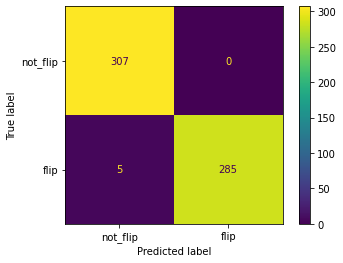

In [19]:
# Display the confusion matrix to evaluate the model

cm = confusion_matrix(y_test, binary_values)
cmd = ConfusionMatrixDisplay(cm, display_labels=['not_flip','flip'])
cmd.plot()

plt.show()

In [20]:
# Print the Classification report to get the precision, recall, f1-score

print(classification_report(y_test, binary_values))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       307
           1       1.00      0.98      0.99       290

    accuracy                           0.99       597
   macro avg       0.99      0.99      0.99       597
weighted avg       0.99      0.99      0.99       597



### Conclusion

###### I was able to create a model with 0.99 accuray if a page needs to whether be flipped or not by using deep learning and doing the necessary data preprocessing such as making all the pages the same size, adjusting bright, adding nose, etc.

In [21]:
# Save the model using pickle

model_classifier = model.save('flip_page_classifier')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: flip_page_classifier/assets


In [22]:
# Establish the training video

video_1 = VideoFileClip('training_flip.avi')
video_2 = VideoFileClip('training_notflip.avi')

training_video = concatenate_videoclips([video_1, video_2])

training_video.write_videofile('training_video.avi', codec = 'rawvideo')
training_video.close()

t:   0%|          | 6/2392 [00:00<00:41, 57.43it/s, now=None]

Moviepy - Building video training_video.avi.
Moviepy - Writing video training_video.avi



Moviepy - Done !
Moviepy - video ready training_video.avi


In [23]:
# Establish the test video

video_3 = VideoFileClip('test_flip.avi')
video_4 = VideoFileClip('test_notflip.avi')

test_video= concatenate_videoclips([video_3, video_4])

test_video.write_videofile('test_video.avi', codec = 'rawvideo')
test_video.close()

t:   1%|          | 5/597 [00:00<00:12, 47.82it/s, now=None]

Moviepy - Building video test_video.avi.
Moviepy - Writing video test_video.avi



Moviepy - Done !
Moviepy - video ready test_video.avi


In [24]:
# Separate the frames for the training video

count = 0

videoFile = 'training_video.avi'
# Capturing the video from the given path
cap = cv2.VideoCapture(videoFile)   
# Establish Frame rate
frameRate = cap.get(5) 

x=1

filenames_train = []

while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="frame%d.jpg" % count;count+=1
        filenames_train.append(filename)
        cv2.imwrite(filename, frame)
cap.release()
cv2.destroyAllWindows()

In [25]:
# Separate the frames from the test video

count = 0

videoFile = 'test_video.avi'
# Capturing the video from the given path
cap = cv2.VideoCapture(videoFile)   
# Establish Frame rate
frameRate = cap.get(5) 

x=1

filenames_test = []

while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="frame%d.jpg" % count;count+=1
        filenames_test.append(filename)
        cv2.imwrite(filename, frame)
cap.release()
cv2.destroyAllWindows()

In [26]:
# Append the y_train flip and not flip into the same array

y_train = np.append(np.array(y_train_flip), np.array(y_train_notflip))

# Append the y_test flip and not flip into the same array

y_test = np.append(np.array(y_test_flip), np.array(y_test_notflip))

# Create the data frame that will show the frameID and the class for the train data

data_train = pd.DataFrame({'frameID': filenames_train, 'flip': y_train})

# Create the data frame that will show the frameID and the class for the test data

data_test = pd.DataFrame({'frameID': filenames_test, 'flip': y_test})


In [27]:
# Randomly change the data order and reset the index

data_train = shuffle(data_train).reset_index(drop = True)

data_test = shuffle(data_test).reset_index(drop = True)

In [28]:
# Create an empty array

X_train = []   

# Loop through the frameID column and store every frame in X
for img_name in data_train.frameID:
    img = plt.imread('' + img_name)
    X_train.append(img)  
    
# Convert the list to an array
X_train = np.array(X_train)    

# Define the y_train

y_train = data_train['flip'].values

In [29]:
# Create an empty array

X_test = []   

# Loop through the frameID column and store every frame in X
for img_name in data_test.frameID:
    img = plt.imread('' + img_name)
    X_test.append(img)  
    
# Convert the list to an array

X_test = np.array(X_test) 

# Define the y_test

y_test = data_test['flip'].values

In [30]:
def image_preprocessing_frame(data):
    # Create an empty list to store all the preprocessed images
    images = []
    # Start by creating a for loop through all the path and make the preprocessing to each image
    for i in data:
        # Adjust the size so all iamges will have the same size
        img = cv2.resize(i, dsize = (70,140), interpolation=cv2.INTER_CUBIC)
        # Crop to remove part of the images I don't need for the modeling part
        y,h,x,w = 0,100,0,70
        img = img[y:y+h, x:x+w]
        # Adjust brightness, contrast
        alpha=1.5
        beta=0.5
        img = cv2.addWeighted(img, alpha, np.zeros(img.shape, img.dtype), 0, beta)
        # Append the img to the list images
        images.append(img)
        # Create the video

    # Return the list with the preprocessed images
    return images

In [31]:
# Use the defined function to preprocess the data

X_train = image_preprocessing_frame(data = X_train)

X_test = image_preprocessing_frame(data = X_test)

In [32]:
# Include_top=False to remove the top layer and a base model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 70, 3))    

In [33]:
# Convert the list into arrays

X_train = np.array(X_train)

X_test = np.array(X_test)

In [34]:
# We will make predictions using this model for X_train and X_valid, get the features, and then use those 
# features to retrain the model.

X_train = base_model.predict(X_train)

X_test = base_model.predict(X_test)

X_train.shape, X_test.shape

((2392, 3, 2, 512), (597, 3, 2, 512))

In [35]:
# Centering the data

X_train = X_train/X_train.max()

X_test = X_test/X_test.max()

In [36]:
def model_neural():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation = 'relu', kernel_initializer='he_uniform', 
                     padding = 'same', input_shape=(3, 2, 512)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [40]:
# Use the function with the created model

model = model_neural()

model.fit(X_train, y_train, epochs = 100, validation_data = (X_test, y_test))

Epoch 1/100
75/75 [==============================] - 1s 9ms/step - loss: 0.6928 - accuracy: 0.5234 - val_loss: 0.6889 - val_accuracy: 0.6332
Epoch 2/100
75/75 [==============================] - 1s 7ms/step - loss: 0.6885 - accuracy: 0.6191 - val_loss: 0.6836 - val_accuracy: 0.6750
Epoch 3/100
75/75 [==============================] - 1s 8ms/step - loss: 0.6843 - accuracy: 0.6426 - val_loss: 0.6774 - val_accuracy: 0.6985
Epoch 4/100
75/75 [==============================] - 0s 7ms/step - loss: 0.6793 - accuracy: 0.6672 - val_loss: 0.6700 - val_accuracy: 0.7437
Epoch 5/100
75/75 [==============================] - 0s 7ms/step - loss: 0.6735 - accuracy: 0.6944 - val_loss: 0.6611 - val_accuracy: 0.7839
Epoch 6/100
75/75 [==============================] - 1s 7ms/step - loss: 0.6665 - accuracy: 0.7153 - val_loss: 0.6507 - val_accuracy: 0.8090
Epoch 7/100
75/75 [==============================] - 1s 7ms/step - loss: 0.6585 - accuracy: 0.7283 - val_loss: 0.6391 - val_accuracy: 0.8291
Epoch 8/100
7

Epoch 59/100
75/75 [==============================] - 1s 7ms/step - loss: 0.3529 - accuracy: 0.8616 - val_loss: 0.2041 - val_accuracy: 0.9514
Epoch 60/100
75/75 [==============================] - 0s 6ms/step - loss: 0.3503 - accuracy: 0.8620 - val_loss: 0.2007 - val_accuracy: 0.9581
Epoch 61/100
75/75 [==============================] - 0s 5ms/step - loss: 0.3496 - accuracy: 0.8633 - val_loss: 0.2155 - val_accuracy: 0.9447
Epoch 62/100
75/75 [==============================] - 0s 7ms/step - loss: 0.3488 - accuracy: 0.8637 - val_loss: 0.1993 - val_accuracy: 0.9581
Epoch 63/100
75/75 [==============================] - 0s 6ms/step - loss: 0.3474 - accuracy: 0.8629 - val_loss: 0.2040 - val_accuracy: 0.9514
Epoch 64/100
75/75 [==============================] - 0s 6ms/step - loss: 0.3457 - accuracy: 0.8633 - val_loss: 0.2060 - val_accuracy: 0.9447
Epoch 65/100
75/75 [==============================] - 1s 9ms/step - loss: 0.3430 - accuracy: 0.8633 - val_loss: 0.1786 - val_accuracy: 0.9732
Epoch 

In [44]:
# Get the predictions

predictions = model.predict(X_test)

# Get them into 0 and 1 values

binary_values = []

# Start a for loop to iterate over the predictions array

for i in predictions:
    if i < 0.5:
        binary_values.append(0)
    if i >= 0.5:
        binary_values.append(1)
        

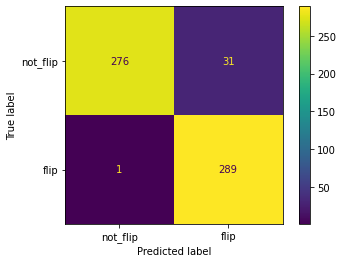

In [45]:
# Display the confusion matrix to evaluate the model

cm = confusion_matrix(y_test, binary_values)
cmd = ConfusionMatrixDisplay(cm, display_labels=['not_flip','flip'])
cmd.plot()

plt.show()

In [46]:
# Print the Classification report to get the precision, recall, f1-score

print(classification_report(y_test, binary_values))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95       307
           1       0.90      1.00      0.95       290

    accuracy                           0.95       597
   macro avg       0.95      0.95      0.95       597
weighted avg       0.95      0.95      0.95       597

